# Read the datasets

In [1]:
import importlib
from matplotlib import pyplot as plt
from numpy import linalg as LA
import numpy as np
import util
from sklearn import linear_model
import time

TRAIN_IMAGE_PATH = "data/train-images-idx3-ubyte"
TEST_IMAGE_PATH = "data/t10k-images-idx3-ubyte"
TRAIN_LABEL_PATH = "data/train-labels-idx1-ubyte"
TEST_LABEL_PATH = "data/t10k-labels-idx1-ubyte" 

train_images = util.read_images(TRAIN_IMAGE_PATH)
train_labels = util.read_labels(TRAIN_LABEL_PATH)
test_images = util.read_images(TEST_IMAGE_PATH)
test_labels = util.read_labels(TEST_LABEL_PATH)

# Dataset statistics

In [2]:
num_train_images = train_labels.shape[0]
num_test_images = test_labels.shape[0]
num_image_row = train_images.shape[1]
num_image_col = train_images.shape[2]

print("Train labels shape = " + str(train_labels.shape))
print("Test labels shape = " + str(test_labels.shape))
print("Train images shape = " + str(train_images.shape))
print("Train labels shape = " + str(test_images.shape))
print("Number of training samples = " + str(num_train_images))
print("Number of test samples = " + str(num_test_images))
print("Number of rows in image = " + str(num_image_row))
print("Number of columns in image = " + str(num_image_col))
print("Image values. Max = %d. Min = %d" % (np.max(train_images), np.min(train_images)))


Train labels shape = (60000,)
Test labels shape = (10000,)
Train images shape = (60000, 28, 28)
Train labels shape = (10000, 28, 28)
Number of training samples = 60000
Number of test samples = 10000
Number of rows in image = 28
Number of columns in image = 28
Image values. Max = 255. Min = 0


In [3]:
test_digit_counts = {}
for test_label in test_labels:
  test_digit_counts[test_label] = test_digit_counts.get(test_label, 0) + 1
test_digit_counts

{7: 1028,
 2: 1032,
 1: 1135,
 0: 980,
 4: 982,
 9: 1009,
 5: 892,
 6: 958,
 3: 1010,
 8: 974}

In [4]:
train_digit_counts = {}
for train_label in train_labels:
  train_digit_counts[train_label] = train_digit_counts.get(train_label, 0) + 1
train_digit_counts

{5: 5421,
 0: 5923,
 4: 5842,
 1: 6742,
 9: 5949,
 2: 5958,
 3: 6131,
 6: 5918,
 7: 6265,
 8: 5851}

# Dataset conversion

In [5]:
# Flatten each 2D image into 1D array.
train_flat_images = train_images.reshape(num_train_images, num_image_row * num_image_col)
test_flat_images = test_images.reshape(num_test_images, num_image_row * num_image_col)

print("train_flat_images.shape = " + str(train_flat_images.shape))
print("test_flat_images.shape = " + str(test_flat_images.shape))
  
train_binary_labels = util.convert_labels_to_binary_vector(train_labels)
test_binary_labels = util.convert_labels_to_binary_vector(test_labels)
print("train_binary_labels.shape = " + str(train_binary_labels.shape))
print("test_binary_labels.shape = " + str(test_binary_labels.shape))

train_flat_images.shape = (60000, 784)
test_flat_images.shape = (10000, 784)
train_binary_labels.shape = (60000, 10)
test_binary_labels.shape = (10000, 10)


# Hyperparameter optimization using K-fold cross validation

In [6]:
# Optimize Lasso's hyperparameter.
lasso_alpha_to_acc = {
  0.2: 0.8452166666666667,
  0.4: 0.83965,
  0.6: 0.8335833333333333,
  0.8: 0.8265333333333332,
  1.0: 0.8209833333333334}
alphas = [0.2, 0.4, 0.6, 0.8, 1.0]
for alpha in alphas:
  if alpha in lasso_alpha_to_acc:
    continue
  model = linear_model.Lasso(alpha=alpha)
  acc = util.get_kfold_accuracy(model, train_flat_images, train_binary_labels, train_labels)
  print("For alpha = %.2f, accuracy for Lasso = %.2f" % (alpha, acc))
  lasso_alpha_to_acc[alpha] = acc


In [7]:
# Optimize ridge regression's hyperparameter.
ridge_alpha_to_acc = {
  0.2: 0.8501999999999998,
  0.4: 0.85025,
  0.6: 0.8502333333333333,
  0.8: 0.8502333333333333,
  1.0: 0.8502333333333333
}
for alpha in alphas:
  if alpha in ridge_alpha_to_acc:
    continue
  model = linear_model.Ridge(alpha=alpha)
  acc = util.get_kfold_accuracy(model, train_flat_images, train_binary_labels, train_labels)
  print("For alpha = %.2f, accuracy for Ridge = %.2f" % (alpha, acc))
  ridge_alpha_to_acc[alpha] = acc


In [8]:
# Optimize elastic net's hyperparameters.
elastic_alpha_to_acc = {
  0.2: 0.8480000000000001,
  0.4: 0.8452,
  0.6: 0.8425666666666667,
  0.8: 0.8396666666666667,
  1.0: 0.8370833333333334
}
for alpha in alphas:
  if alpha in elastic_alpha_to_acc:
    continue
  model = linear_model.ElasticNet(alpha=alpha,l1_ratio=0.5)
  acc = util.get_kfold_accuracy(model, train_flat_images, train_binary_labels, train_labels)
  print("For alpha = %.2f, accuracy for Elastic net = %.2f" % (alpha, acc))
  elastic_alpha_to_acc[alpha] = acc

# Plot hyperparameter optimization results

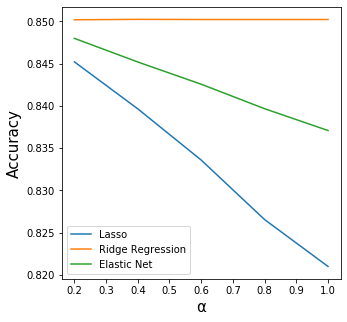

In [9]:
fig, ax = plt.subplots(figsize = (5, 5))
lasso_accs = [lasso_alpha_to_acc[alpha] for alpha in alphas]
ax.plot(alphas, lasso_accs, label='Lasso')
ridge_accs = [ridge_alpha_to_acc[alpha] for alpha in alphas]
ax.plot(alphas, ridge_accs, label='Ridge Regression')
elastic_accs = [elastic_alpha_to_acc[alpha] for alpha in alphas]
ax.plot(alphas, elastic_accs, label='Elastic Net')
ax.set_xlabel("α")
ax.set_ylabel("Accuracy")
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.legend()

# Performance on training and test set

In [10]:
best_lasso_alpha = 0.2
best_ridge_alpha = 0.4
best_elastic_alpha = 0.2

best_lasso = linear_model.Lasso(alpha=best_lasso_alpha)
best_ridge = linear_model.Ridge(alpha=best_ridge_alpha)
best_elastic = linear_model.ElasticNet(alpha=best_elastic_alpha, l1_ratio=0.5)
plain_regression = linear_model.LinearRegression()

def get_model_train_test_performance(model, model_name):
  model.fit(train_flat_images, train_binary_labels)
  model_train_preds = util.get_predictions(model, train_flat_images)
  model_train_errs = util.get_errors(model_train_preds, train_labels)
  model_train_acc = util.get_accuracy(len(model_train_errs), num_train_images)
  model_test_preds = util.get_predictions(model, test_flat_images)
  model_test_errs = util.get_errors(model_test_preds, test_labels)
  model_test_acc = util.get_accuracy(len(model_test_errs), num_test_images)
  print("%s. Train accuracy = %.4f. Test accuracy = %.4f" % \
        (model_name, model_train_acc, model_test_acc))
  return model_test_preds
lasso_test_preds = get_model_train_test_performance(best_lasso, "Lasso")
get_model_train_test_performance(best_ridge, "Ridge Regression")
get_model_train_test_performance(best_elastic, "Elastic Net")
get_model_train_test_performance(plain_regression, "Linear Regression")

Lasso. Train accuracy = 0.8478. Test accuracy = 0.8549
Ridge Regression. Train accuracy = 0.8577. Test accuracy = 0.8603
Elastic Net. Train accuracy = 0.8509. Test accuracy = 0.8575
Linear Regression. Train accuracy = 0.8577. Test accuracy = 0.8601


array([7, 2, 1, ..., 4, 5, 6])

# Mean squared error on training and test set

In [11]:
def get_mse(model, flat_images, binary_labels):
  # Return the L2 norm of AX - b
  predicted_b = model.predict(flat_images)
  num_els = predicted_b.shape[0] * predicted_b.shape[1]
  mse = 1.0 / num_els * LA.norm(predicted_b - binary_labels)
  return mse

def get_model_train_test_mse(model, model_name):
  train_mse = get_mse(model, train_flat_images, train_binary_labels)
  test_mse = get_mse(model, test_flat_images, test_binary_labels)
  
  print("%s. Train MSE = %.4f. Test MSE = %.4f" % \
        (model_name, train_mse, test_mse))
get_model_train_test_mse(best_lasso, "Lasso")
get_model_train_test_mse(best_ridge, "Ridge Regression")
get_model_train_test_mse(best_elastic, "Elastic Net")
get_model_train_test_mse(plain_regression, "Linear Regression")

Lasso. Train MSE = 0.0003. Test MSE = 0.0006
Ridge Regression. Train MSE = 0.0003. Test MSE = 0.0006
Elastic Net. Train MSE = 0.0003. Test MSE = 0.0006
Linear Regression. Train MSE = 0.0003. Test MSE = 20857.4061


# Error analysis

In [12]:
actual_to_predicted_counts = np.zeros((10, 10), dtype=int)
actual_to_predicted_sample = np.zeros((10, 10), dtype=int)
for i in range(len(lasso_test_preds)):
  pred = lasso_test_preds[i]
  actual = test_labels[i]
  actual_to_predicted_counts[actual, pred] += 1
  actual_to_predicted_sample[actual, pred] = i

digit_to_confound = {}
print("Digit, Classification accuracy, Most confounding digit, Most confounding error rate")
for digit in range(10):
  num_samples_for_digit = actual_to_predicted_counts[digit, :].sum()
  correct_preds_for_digit = actual_to_predicted_counts[digit, digit]
  digit_acc = 100.0 * correct_preds_for_digit / num_samples_for_digit 
  
  # Remove the correct prediction so we can argmax to get confounding error 
  actual_to_predicted_counts[digit, digit] = -1
  most_confounding_digit = actual_to_predicted_counts[digit, :].argmax()
  most_confounding_err_count = actual_to_predicted_counts[digit, most_confounding_digit]
  most_confounding_err_rate = 100.0 * most_confounding_err_count / num_samples_for_digit
  actual_to_predicted_counts[digit, digit] = correct_preds_for_digit
  print("%d, %.2f, %d, %.2f" % (digit, digit_acc, most_confounding_digit, most_confounding_err_rate))
  
  digit_to_confound[digit] = most_confounding_digit

Digit, Classification accuracy, Most confounding digit, Most confounding error rate
0, 96.12, 6, 1.43
1, 96.92, 8, 1.76
2, 79.07, 1, 6.01
3, 86.73, 7, 2.38
4, 89.51, 9, 4.99
5, 70.29, 3, 9.87
6, 91.23, 0, 2.30
7, 86.19, 1, 4.67
8, 77.31, 1, 5.44
9, 78.89, 7, 7.83


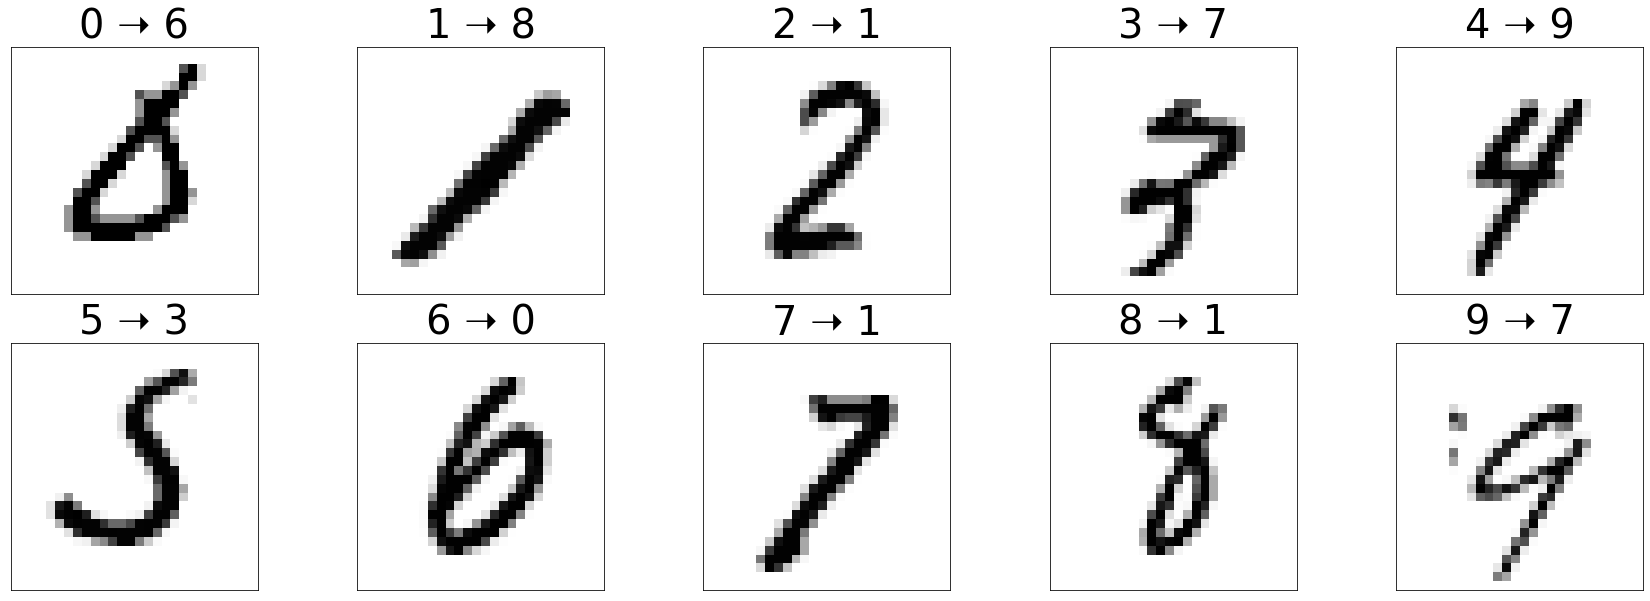

In [13]:
fig, axes = plt.subplots(nrows=2, ncols = 5, figsize=(30,10))
for digit in range(10):
  ax_row = digit // 5
  ax_col = digit % 5
  ax = axes[ax_row][ax_col]
  confound_digit = digit_to_confound[digit]
  confound_sample = actual_to_predicted_sample[digit, confound_digit]
  ax.set_title("%d ➝ %d" % (digit, confound_digit), fontsize=40)
  ax.imshow(test_images[confound_sample,:,:], interpolation='nearest', cmap='Greys')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

# Important pixels

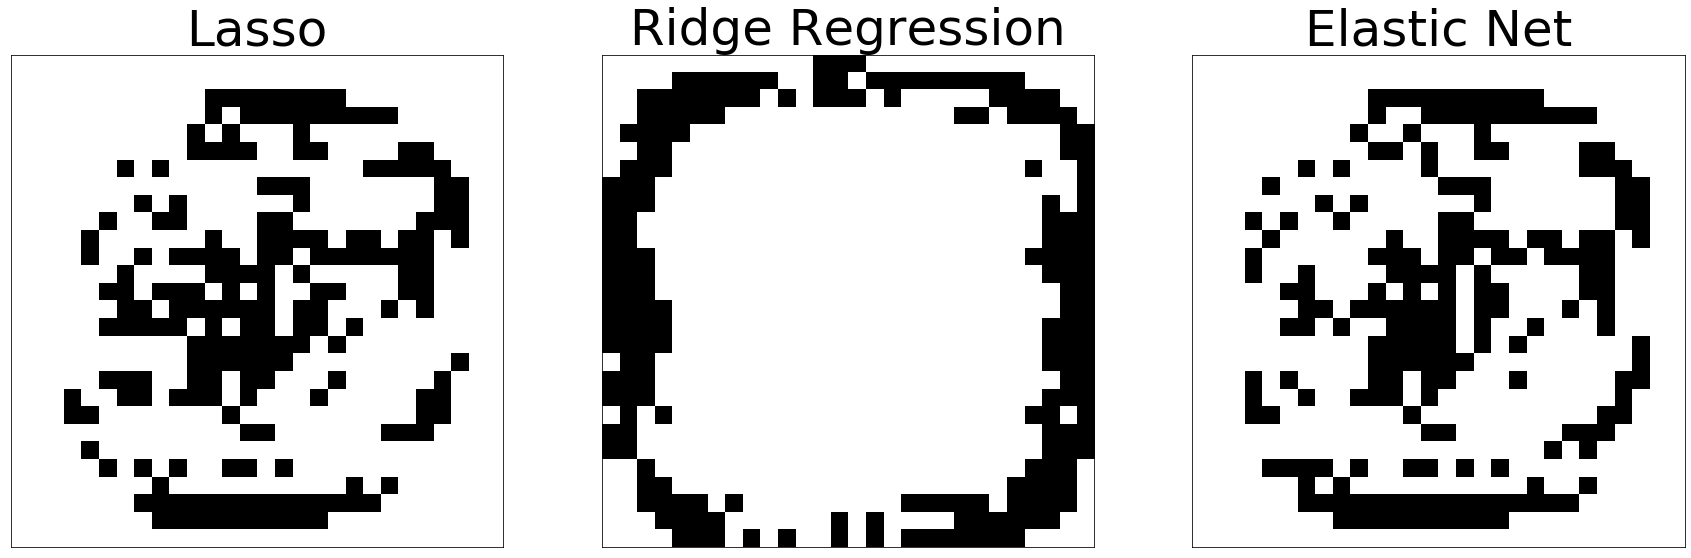

In [14]:
# Get the L2 norm of each weight row
fig, axes = plt.subplots(nrows=1, ncols =3, figsize=(30,10))
i = 0
model_names = ["Lasso", "Ridge Regression", "Elastic Net"]
for model in [best_lasso, best_ridge, best_elastic]:
  X = model.coef_.T
  k = 200
  weight_l2 = np.apply_along_axis(LA.norm, 1, X)
  top_pixel_indices = weight_l2.argsort()[-k:][::-1]
  ax = axes[i]
  util.plot_important_pixels(ax, top_pixel_indices)
  ax.get_xaxis().set_visible(False)
  ax.set_title(model_names[i], fontsize = 50)
  ax.get_yaxis().set_visible(False)
  i+=1

# Re-training with important pixels only

In [15]:
models = [
  ('Lasso', best_lasso, linear_model.Lasso(alpha=best_lasso_alpha)),
  ('Ridge Regression', best_ridge, linear_model.Ridge(alpha=best_ridge_alpha)),
  ('Elastic Net', best_elastic, linear_model.ElasticNet(alpha=best_elastic_alpha, l1_ratio=0.5))
]
top_ks = [100,200,300,400,500,600]
  
model = linear_model.Lasso(alpha=best_lasso_alpha)
model_to_train_accs = {}
model_to_test_accs = {}
   
for model_name, fully_trained_model, model in models:
  # Get the important pixels from the model that has been fully trained on the training set.
  weight_l2 = np.apply_along_axis(LA.norm, 1, fully_trained_model.coef_.T)
  top_pixel_indices = weight_l2.argsort()[::-1]
   
  model_to_train_accs[model_name] = []
  model_to_test_accs[model_name] = []
  print(model_name)
  for top_k in top_ks:
    selected_pixels = top_pixel_indices[:top_k]
    sampled_train_flat_images = util.subsample_pixels(train_flat_images, selected_pixels)
    sampled_test_flat_images = util.subsample_pixels(test_flat_images, selected_pixels)
    model.fit(sampled_train_flat_images, train_binary_labels)
    train_preds = util.get_predictions(model, sampled_train_flat_images)
    train_errs = util.get_errors(train_preds, train_labels)
    train_acc = util.get_accuracy(len(train_errs), num_train_images)
    test_preds = util.get_predictions(model, sampled_test_flat_images)
    test_errs = util.get_errors(test_preds, test_labels)
    test_acc = util.get_accuracy(len(test_errs), num_test_images)
    print("Top k = %d, Train accuracy = %.2f, Test accuracy = %.2f" % (top_k, train_acc, test_acc))
    model_to_train_accs[model_name].append(train_acc)
    model_to_test_accs[model_name].append(test_acc)

Lasso
Top k = 100, Train accuracy = 0.77, Test accuracy = 0.78
Top k = 200, Train accuracy = 0.84, Test accuracy = 0.85
Top k = 300, Train accuracy = 0.85, Test accuracy = 0.86


KeyboardInterrupt: 

In [ ]:
def plot_train_test_performance(ax, model_to_train_accs, model_to_test_accs, top_ks, model_name):
  ax.plot(top_ks, model_to_train_accs[model_name], label='Train')
  ax.plot(top_ks, model_to_test_accs[model_name], label='Test')
  ax.set_xlabel("Number of pixels used")
  ax.set_ylabel("Accuracy")
  ax.set_title(model_name, fontsize=40)
  ax.xaxis.label.set_fontsize(30)
  ax.yaxis.label.set_fontsize(30)
  for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
  for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
  ax.legend(prop={'size': 20})
fig, axes = plt.subplots(nrows=1, ncols = 3, figsize=(30,8))
plot_train_test_performance(axes[0], model_to_train_accs, model_to_test_accs, top_ks, 'Lasso')
plot_train_test_performance(axes[1], model_to_train_accs, model_to_test_accs, top_ks, 'Ridge Regression')
plot_train_test_performance(axes[2], model_to_train_accs, model_to_test_accs, top_ks, 'Elastic Net')

# Per-digit re-analysis

Digit = 0. Train accuracy = 0.9811. Test accuracy = 0.9797
Digit = 0. Top k = 1, Train accuracy = 0.92, Test accuracy = 0.92
This one iteration took 0 s
Digit = 0. Top k = 3, Train accuracy = 0.92, Test accuracy = 0.92
This one iteration took 0 s
Digit = 0. Top k = 5, Train accuracy = 0.92, Test accuracy = 0.92
This one iteration took 0 s
Digit = 0. Top k = 10, Train accuracy = 0.94, Test accuracy = 0.94
This one iteration took 0 s
Digit = 0. Top k = 20, Train accuracy = 0.96, Test accuracy = 0.96
This one iteration took 0 s
Digit = 0. Top k = 50, Train accuracy = 0.98, Test accuracy = 0.97
This one iteration took 0 s
Digit = 0. Top k = 100, Train accuracy = 0.98, Test accuracy = 0.98
This one iteration took 1 s
Digit = 1. Train accuracy = 0.9793. Test accuracy = 0.9804
Digit = 1. Top k = 1, Train accuracy = 0.89, Test accuracy = 0.89
This one iteration took 0 s
Digit = 1. Top k = 3, Train accuracy = 0.92, Test accuracy = 0.92
This one iteration took 0 s
Digit = 1. Top k = 5, Train acc

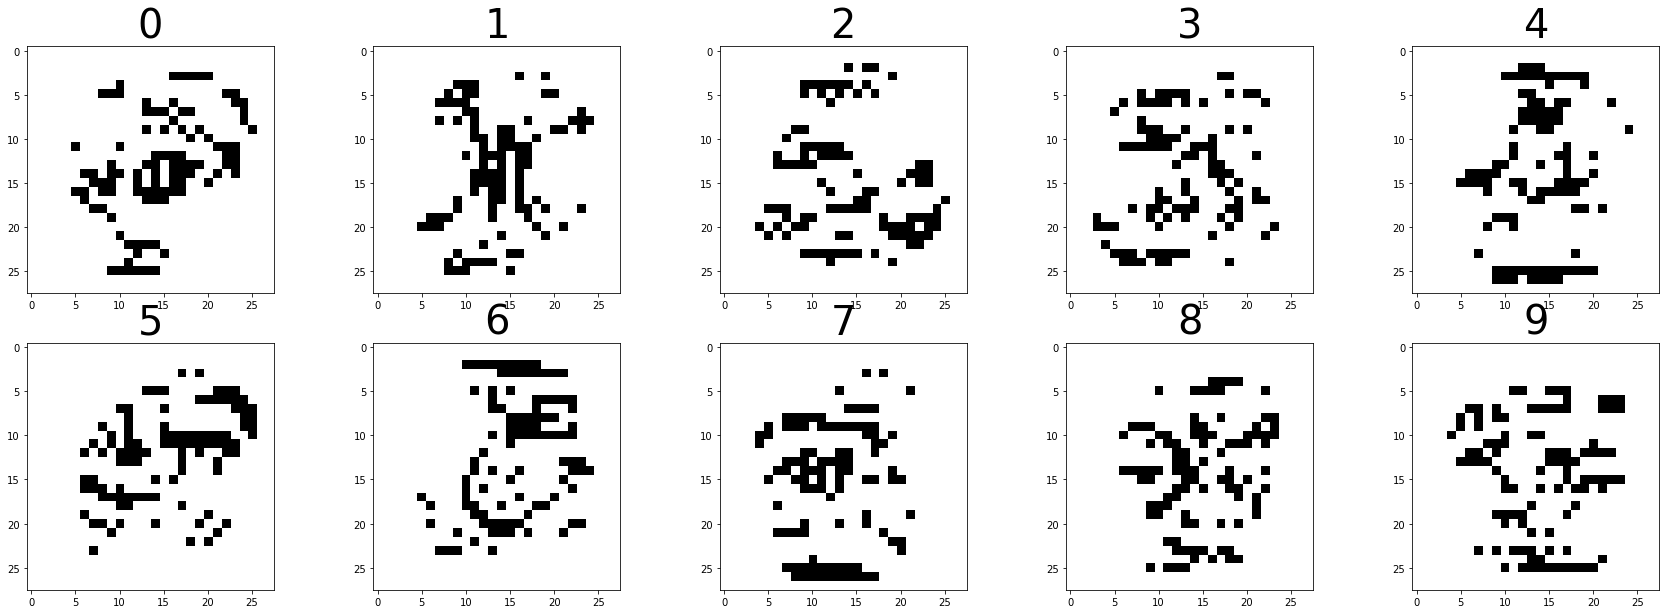

In [47]:
def get_one_digit_labels(digit, binary_labels):
  return binary_labels[:, digit]

def get_one_digit_accuracy(proba_predictions, one_digit_train_binary_labels):
  binary_predictions = proba_predictions > 0.5
  num_correct = sum(binary_predictions == one_digit_train_binary_labels)
  return 1.0 * num_correct / len(proba_predictions)
get_one_digit_labels(0, train_binary_labels)

NUM_DIGIT = 10
full_train_error_per_digit = np.zeros(NUM_DIGIT)
full_test_error_per_digit = np.zeros(NUM_DIGIT)
# list<map<pixel_count, train error>> 
partial_pixel_train_error_per_digit = [{} for x in range(NUM_DIGIT)]
# list<map<pixel_count, test error>>
partial_pixel_test_error_per_digit = [{} for x in range(NUM_DIGIT)]

model = best_lasso


top_ks = [1, 3, 5, 10, 20, 50, 100]
k = 100
fig, axes = plt.subplots(nrows=2, ncols = 5, figsize=(30,10))

for digit in range(NUM_DIGIT):
  one_digit_train_binary_labels = get_one_digit_labels(digit, train_binary_labels)
  one_digit_test_binary_labels = get_one_digit_labels(digit, test_binary_labels)
  model.fit(train_flat_images, one_digit_train_binary_labels)
  
  # This is a 1-D array, each element is like a probability that the classifier
  # thinks it's this particular digit
  train_proba_preds = model.predict(train_flat_images)
  model_train_acc = get_one_digit_accuracy(train_proba_preds, one_digit_train_binary_labels)
  test_proba_preds = model.predict(test_flat_images)
  model_test_acc = get_one_digit_accuracy(test_proba_preds, one_digit_test_binary_labels)
  
  full_train_error_per_digit[digit] = model_train_acc
  full_test_error_per_digit[digit] = model_test_acc
  
  print("Digit = %d. Train accuracy = %.4f. Test accuracy = %.4f" % \
        (digit, model_train_acc, model_test_acc))
  
  # Plot most important pixels
  ax_row = digit // 5
  ax_col = digit % 5
  ax = axes[ax_row][ax_col]
  weights_for_digit = np.abs(model.coef_)
  top_pixel_indices = weights_for_digit.argsort()[-k:][::-1]
  util.plot_important_pixels(ax, top_pixel_indices)
  ax.set_title(digit, fontsize=40)
  
  # Retrain on a subset of pixels
  for top_k in top_ks:
    start_time = time.time()
    selected_pixels = top_pixel_indices[:top_k]
    sampled_train_flat_images = util.subsample_pixels(train_flat_images, selected_pixels)
    sampled_test_flat_images = util.subsample_pixels(test_flat_images, selected_pixels)
    model.fit(sampled_train_flat_images, one_digit_train_binary_labels)
    
    train_proba_preds = model.predict(sampled_train_flat_images)
    model_train_acc = get_one_digit_accuracy(train_proba_preds, one_digit_train_binary_labels)
    test_proba_preds = model.predict(sampled_test_flat_images)
    model_test_acc = get_one_digit_accuracy(test_proba_preds, one_digit_test_binary_labels)
    
    print("Digit = %d. Top k = %d, Train accuracy = %.2f, Test accuracy = %.2f" % 
          (digit, top_k, model_train_acc, model_test_acc))
    partial_pixel_train_error_per_digit[digit][top_k] = model_train_acc
    partial_pixel_test_error_per_digit[digit][top_k] = model_test_acc
    print("This one iteration took %d s" % (time.time() - start_time))

In [48]:
print(" & ".join(["%.2f" % (acc * 100) for acc in full_train_error_per_digit]))
print(" & ".join(["%.2f" % (acc * 100) for acc in full_test_error_per_digit]))
print(np.argmax(full_train_error_per_digit))
print(np.argmax(full_test_error_per_digit))
print(np.argmin(full_train_error_per_digit))
print(np.argmin(full_test_error_per_digit))

98.11 & 97.93 & 95.81 & 95.38 & 95.80 & 93.82 & 97.49 & 96.45 & 94.41 & 93.60
97.97 & 98.04 & 95.63 & 95.60 & 96.02 & 94.11 & 97.24 & 96.45 & 94.51 & 94.02
0
1
9
9


Text(0.5, 1.0, 'Test accuracy')

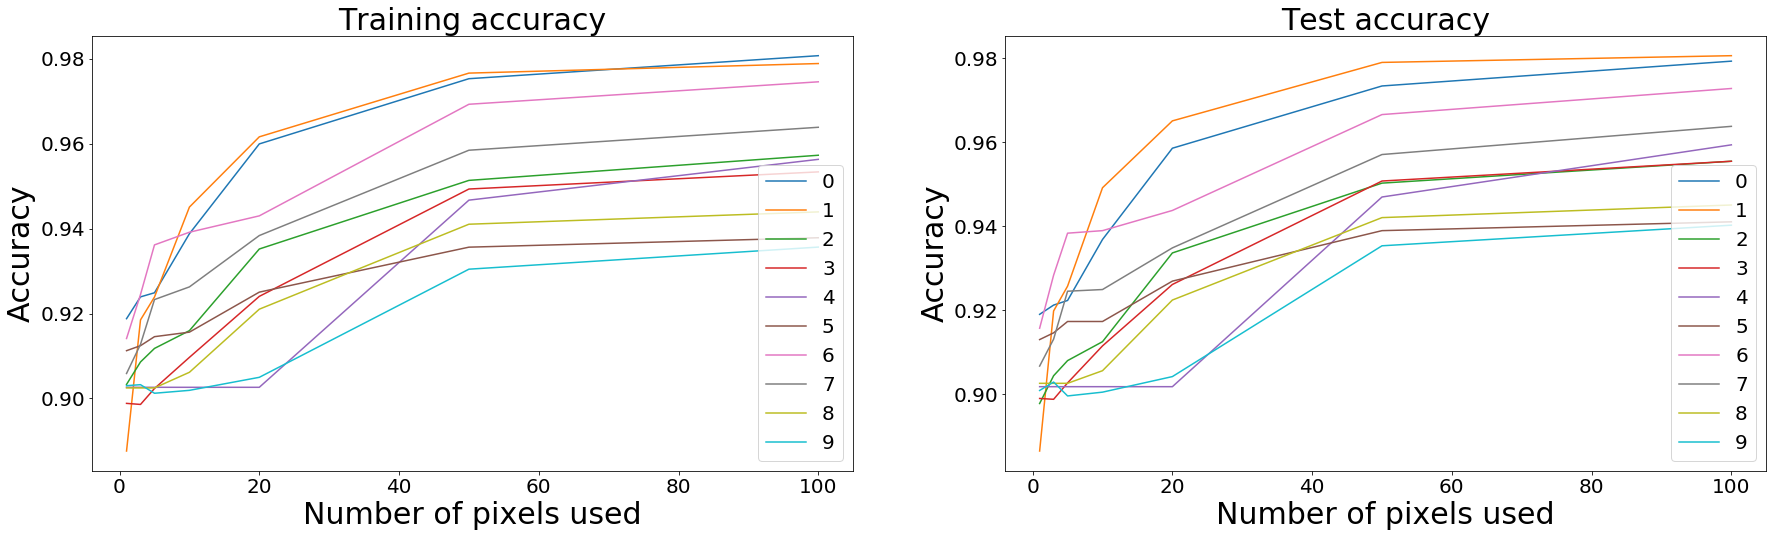

In [50]:
def plot_varying_pixel_performance(partial_pixel_error_per_digit, ax):
  for digit in range(NUM_DIGIT):
    accs = [partial_pixel_error_per_digit[digit][top_k] for top_k in top_ks]
    ax.plot(top_ks, accs, label=str(digit))
  ax.set_xlabel("Number of pixels used")
  ax.set_ylabel("Accuracy")
  ax.set_title(model_name, fontsize=40)
  ax.xaxis.label.set_fontsize(30)
  ax.yaxis.label.set_fontsize(30)
  for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
  for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
  ax.legend(prop={'size': 20})
  
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(30,8))
plot_varying_pixel_performance(partial_pixel_train_error_per_digit, axes[0])
plot_varying_pixel_performance(partial_pixel_test_error_per_digit, axes[1])
axes[0].set_title("Training accuracy", fontsize = 30)
axes[1].set_title("Test accuracy", fontsize = 30)